# NBA mid-season trades: Causal inference of a trade's effect on a player's performance

Do NBA mid-season player trades actually benefit the players, or not? This topic recently got attention after the controversial trade of Luka Doncic to the LA Lakers without his desire. In this work, I attempt to answer this question with the tools of causal inference.

Using 20 seasons of NBA data from 2003-04 to 2022-23, I estimate the effect of a mid-season trade on a player's performance by looking at traded players performance change, compared to non-traded players.

## 0. Data loading & processing, feauture engineering

Data was collected from the NBA.com website using the `nba_api` package. The process of data collection is in the `data_fetching.ipynb` notebook.

### 0-a) Loading the data

Let's load the data and take a look at it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

import plotting

In [2]:
bios_df = pd.read_csv('data\player_bios.csv')
career_df = pd.read_csv('data\career_filtered.csv')
bios_df.head()

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,PLAYER_HEIGHT,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,COLLEGE,COUNTRY,...,PTS,REB,AST,NET_RATING,OREB_PCT,DREB_PCT,USG_PCT,TS_PCT,AST_PCT,SEASON_ID
0,1630639,A.J. Lawson,1610612742,DAL,22.0,6-6,78.0,179.0,South Carolina,Canada,...,56,21,2,-20.1,0.046,0.152,0.189,0.589,0.032,2022-23
1,1631260,AJ Green,1610612749,MIL,23.0,6-5,77.0,190.0,Northern Iowa,USA,...,154,45,22,-4.9,0.016,0.105,0.159,0.607,0.092,2022-23
2,1631100,AJ Griffin,1610612737,ATL,19.0,6-6,78.0,220.0,Duke,USA,...,639,153,73,1.5,0.026,0.080,0.174,0.577,0.070,2022-23
3,203932,Aaron Gordon,1610612743,DEN,27.0,6-8,80.0,235.0,Arizona,USA,...,1109,446,203,12.1,0.086,0.136,0.206,0.617,0.129,2022-23
4,1628988,Aaron Holiday,1610612737,ATL,26.0,6-0,72.0,185.0,UCLA,USA,...,247,74,89,0.9,0.028,0.059,0.129,0.528,0.135,2022-23


### 0-b) Explanation of attributes: 

|Attribute|Meaning|Extra info|
|---|---|---|
|MIN|minutes   |   |
|FG, FG3, FT|Field goal (2 point goals), field goal 3 pointers, free throws ("penalty throws", 1 point)-  |M: Made (scored), A: attempted, PCT: percentage    |
| REB  |Rebounds   |OREB/DREB: Offensive/defensive rebound  |
|AST|Assists   |AST_PCT: Assist percentage   |
|STL|Steals   |   |
|BLK|Blocks   |   |
|TOV|Turnovers   | Negative statistic  |
|PF|Personal fouls   | Negative statistic  |
|PTS|Points   |   |
|---|--------------------------------------------------------| --------------------------------------------------------------  |
|DRAFT|Each year before the season starts, 60(?) college newcomers can be drafted by teams   |More "promising" players are drafted in earlier rounds   |
|GP, GS|Games played, games started   |   |
|NET_RATING|Offensive rating - defensive rating   |For a player: measure for how many goals a team scores with him vs. allow in. Can be negative.   |
|USG_PCT|Usage percentage   | Estimate of percentage of team plays    |
|TS_PCT|True shooting percentage   | Measures how well a player shoots-  |


### 0-c) Sorting, selecting

As a first step, drop the few duplicate rows, and the incorrent team ID rows:

In [3]:
career_df = career_df.drop_duplicates()
career_df = career_df[career_df['TEAM_ID']!=0].reset_index(drop=True)

Let's only select players (unique ID) from both data - this is just over 2000 players.

In [4]:
ids_bio = bios_df['PLAYER_ID'].unique()
ids_career = career_df['PLAYER_ID'].unique()
ids = np.intersect1d(ids_bio, ids_career)
seasons = ["2022-23","2021-22","2020-21",'2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14','2012-13', '2011-12', '2010-11', '2009-10', '2008-09','2007-08', '2006-07', '2005-06', '2004-05', '2003-04',]

career_df = career_df[career_df['PLAYER_ID'].isin(ids)]
bios_df = bios_df[bios_df['PLAYER_ID'].isin(ids)]
len(ids)

2074

Add new columns: `TREATMENT` (1 if traded, 0 if not), `AFTER_N_MIDSEASON_TRADES` (N after N amount of mid-season trades), `AFTER_N_START_OF_SEASON_TRADES` (N after N amount of end-of-season trades).

It's better to drop the players who somehow played for 3+ teams in a season.

In [5]:
bad_ids = list(career_df.groupby(['PLAYER_ID', 'SEASON_ID']).filter(lambda x: len(x) >= 3)['PLAYER_ID'].unique())
career_df = career_df[~career_df['PLAYER_ID'].isin(bad_ids)]

Also drop the players who played less than 3*48 minutes (3 full games) in a season.

In [6]:
career_df

,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,949,2003-04,0,1610612737,ATL,27.0,53,53,1955.0,383,...,0.880,141.0,354.0,495.0,127,44.0,19.0,131.0,147,1065
1,949,2003-04,0,1610612757,POR,27.0,32,3,729.0,118,...,0.832,48.0,96.0,144.0,47,24.0,18.0,53.0,75,319
2,949,2004-05,0,1610612757,POR,28.0,54,49,1868.0,337,...,0.866,123.0,269.0,392.0,111,49.0,26.0,117.0,150,909
3,949,2005-06,0,1610612758,SAC,29.0,72,30,1961.0,332,...,0.784,106.0,251.0,357.0,149,48.0,42.0,108.0,227,887
4,949,2006-07,0,1610612758,SAC,30.0,80,45,2015.0,310,...,0.726,122.0,276.0,398.0,109,53.0,40.0,116.0,243,793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127,1626161,2019-20,0,1610612744,GSW,26.0,41,37,941.0,144,...,0.614,71.0,184.0,255.0,60,45.0,50.0,35.0,102,323
11128,1626161,2019-20,0,1610612742,DAL,26.0,13,2,157.0,31,...,0.556,13.0,47.0,60.0,10,4.0,11.0,5.0,19,67
11129,1626161,2020-21,0,1610612742,DAL,27.0,53,16,906.0,115,...,0.628,66.0,170.0,236.0,35,21.0,43.0,29.0,129,280
11130,1626161,2021-22,0,1610612742,DAL,28.0,18,2,177.0,16,...,0.500,13.0,25.0,38.0,9,6.0,3.0,7.0,17,34


In [7]:
fitting_players = career_df.groupby(['PLAYER_ID', 'SEASON_ID'])['MIN'].sum().loc[lambda x: x >= 144].index
career_df = career_df[career_df.set_index(['PLAYER_ID', 'SEASON_ID']).index.isin(fitting_players)].reset_index().drop(columns='index')

Add the new columns:

In [8]:
def identify_before_after_teams(player, year, df=career_df, id_column='PLAYER_ID', team_column='TEAM_ID', year_column='YEAR'):
    """Identify which team is the 'before' and which is the 'after' team of a player, after a midseason trade."""
    player_df = df[(df[id_column] == player)]
    years = sorted(player_df[year_column].unique())
    year_index = list(years).index(year)
    previous_year = years[year_index - 1] if year_index > 0 else None
    next_year = years[year_index + 1] if year_index < len(years) - 1 else None
    teams_in_year = player_df[player_df[year_column] == year][team_column].unique()
    
    if len(teams_in_year) != 2:
        print(f"Player {player} in year {year} has {len(teams_in_year)} teams, expected 2")
        return {'before': teams_in_year[0], 'after': teams_in_year[1]}
    
    #Try determine from previous year
    if previous_year is not None:
        previous_teams = player_df[player_df[year_column] == previous_year][team_column].unique()
        for team in teams_in_year:
            if team in previous_teams:
                return {'before': team, 'after': [t for t in teams_in_year if t != team][0]}
    
    #Try based on next year
    if next_year is not None:
        next_teams = player_df[player_df[year_column] == next_year][team_column].unique()
        for team in teams_in_year:
            if team in next_teams:
                return {'before': [t for t in teams_in_year if t != team][0], 'after': team}
                
    #print(f"Could not determine before/after teams for player {player} in year {year}")
    return {'before': teams_in_year[0], 'after': teams_in_year[1]}  # Arbitrary choice

def get_player_yearly_teams(player, df = career_df, id_column = 'PLAYER_ID', team_column ='TEAM_ID', year_column = 'YEAR'):
    player_df = df[df[id_column] == player][[id_column, team_column, year_column]].copy()
    years = player_df[year_column].unique()
    year_teams = {}
    for year in years:
        year_teams[year] = player_df[player_df[year_column] == year][team_column].unique()
    return year_teams

def get_player_mid_season_trades(player, df = career_df, id_column = 'PLAYER_ID', team_column ='TEAM_ID', year_column = 'YEAR', before_after = False):
    #assuming every player has at most one trade per year
    player_df = df[df[id_column] == player][[id_column, year_column]].copy()
    years = player_df[year_column].unique()
    years_midseason_trades = []
    for year in years:
        if len(player_df[player_df[year_column] == year]) > 1:
            if before_after:
                teams = identify_before_after_teams(player, year, df, id_column, team_column = team_column, year_column = year_column)
                before = teams['before']
                after = teams['after']
                years_midseason_trades.append({year: {'before': before, 'after': after}})
            else:
                years_midseason_trades.append(year)
    return years_midseason_trades

def get_player_start_of_season_trades(player, df = career_df, id_column = 'PLAYER_ID', team_column ='TEAM_ID', year_column = 'YEAR'):
    #assuming every player has at most one trade per year
    player_df = df[df[id_column] == player].copy()
    years = sorted(player_df[year_column].unique())
    years_endseason_trades = []
    previous_year = years[0]
    yearly_teams = get_player_yearly_teams(player, player_df, id_column, year_column = year_column, team_column = team_column)
    for year in years[1:]:
        previous_teams = yearly_teams[previous_year]
        current_teams = yearly_teams[year]
        if len(set(previous_teams).intersection(set(current_teams))) == 0:
            years_endseason_trades.append(year)
        previous_year = year
    return years_endseason_trades

def get_player_trades(player, df = career_df, id_column = 'PLAYER_ID', year_column = 'YEAR'):
    mid_season_trades = get_player_mid_season_trades(player, df, id_column, year_column = year_column,
                                                     team_column = 'TEAM_ABBREVIATION', before_after = True)
    start_of_season_trades = get_player_start_of_season_trades(player, df, id_column, year_column = year_column, team_column = 'TEAM_ABBREVIATION')
    trades = {'midseason': mid_season_trades, 'startseason': start_of_season_trades}
    return trades

def set_player_trade_columns(df=career_df, id_column='PLAYER_ID', year_column='YEAR',
                             mid_season_col='AFTER_N_MIDSEASON_TRADES', start_of_season_col='AFTER_N_START_OF_SEASON_TRADES'):
    #AFTER_N_MIDSEASON_TRADES (N after N amount of mid-season trades), AFTER_N_START_OF_SEASON_TRADES (N after N amount of trades after the end of a season).
    df = df.copy()
    df.loc[:, mid_season_col] = 0
    df.loc[:, start_of_season_col] = 0

    for player in df[id_column].unique():
        player_df = df[df[id_column] == player]
        trades = get_player_trades(player, player_df, id_column, year_column)

        if trades['startseason']:
            for year in trades['startseason']:
                df.loc[(df[id_column] == player) & (df[year_column] >= year), start_of_season_col] += 1
        if trades['midseason']:
            for year_dict in trades['midseason']:
                year = list(year_dict.keys())[0]
                df.loc[(df[id_column] == player) & (df[year_column] >= year), mid_season_col] += 1

                before_team = year_dict[year]['before']
                df.loc[(df[id_column] == player) & (df[year_column] == year) & (df['TEAM_ABBREVIATION'] == before_team), mid_season_col] -= 1

    return df

career_df['YEAR'] = career_df['SEASON_ID'].str[:4].astype(int)
mid_season_col='AFTER_N_MIDSEASON_TRADES'
start_of_season_col='AFTER_N_START_OF_SEASON_TRADES'
career_df.loc[:, mid_season_col] = 0
career_df.loc[:, start_of_season_col] = 0

players_mid_season_trade_years = {}
for player_id in career_df['PLAYER_ID'].unique():
    mid_season_trade_years = get_player_mid_season_trades(player_id)
    players_mid_season_trade_years[player_id] = mid_season_trade_years
career_df = set_player_trade_columns(career_df)
treatment_players = career_df[career_df[mid_season_col] > 0]['PLAYER_ID'].unique()
career_df['TREATMENT'] = career_df['PLAYER_ID'].apply(lambda x: 1 if x in treatment_players else 0)
career_df['TRADED_THIS_SEASON'] = career_df.apply(lambda x: 1 if x['YEAR'] in players_mid_season_trade_years[x['PLAYER_ID']] else 0, axis=1)

In [9]:
cols = ['PLAYER_ID', 'SEASON_ID', 'YEAR', 'TEAM_ABBREVIATION', 'TREATMENT',
        'AFTER_N_MIDSEASON_TRADES', 'AFTER_N_START_OF_SEASON_TRADES', 'TRADED_THIS_SEASON',
        'PLAYER_AGE', 'GP', 'GS', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
        'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
        'BLK', 'TOV', 'PF', 'TEAM_ID', 'LEAGUE_ID', ]
career_df = career_df[cols]

In [10]:
career_df[career_df["PLAYER_ID"] == 57]

,PLAYER_ID,SEASON_ID,YEAR,TEAM_ABBREVIATION,TREATMENT,AFTER_N_MIDSEASON_TRADES,AFTER_N_START_OF_SEASON_TRADES,TRADED_THIS_SEASON,PLAYER_AGE,GP,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,TEAM_ID,LEAGUE_ID
8138,57,2003-04,2003,SAC,1,0,0,0,34.0,82,...,69.0,260.0,329.0,347,151.0,41.0,155.0,186,1610612758,0
8139,57,2004-05,2004,SAC,1,0,0,1,35.0,31,...,29.0,94.0,123.0,153,43.0,13.0,68.0,61,1610612758,0
8140,57,2004-05,2004,ORL,1,1,0,1,35.0,21,...,9.0,45.0,54.0,46,37.0,5.0,36.0,45,1610612753,0
8141,57,2005-06,2005,DAL,1,1,1,0,36.0,7,...,2.0,11.0,13.0,14,9.0,1.0,6.0,10,1610612742,0


These are the stats for Player 57: statistics from multiple seasons.<br>
The players that have multiple rows for the same season (e.g. see 2004-05 above) were playing in different teams in the same season - hence being in the treatment group.

Okay. It's better to filter out seasonal data that had too low playtime, they are not averaged well.<br>
Filter out low minute data for accuracy: all seasonal stats with less than 3 matches played

### 0-d) Normalizing by minutes played

Consideration: should we use raw stats, or normalized by minutes/age/etc.?

Firstly, a crucial factor must be the minutes played. The more you play, the more you score. Let's see:

In [11]:
point_means = []; min_means = []; fg_pct_means = [];  three_pct_means = []; ft_pct_means = [];
ages = sorted(career_df['PLAYER_AGE'].unique()) #18-44
treatment_means = []
mid_season_trades_means = []
start_of_season_trades_means = []

for age in ages:
    point_means.append(career_df[career_df['PLAYER_AGE'] == age]['PTS'].mean())
    min_means.append(career_df[career_df['PLAYER_AGE'] == age]['MIN'].mean())
    fg_pct_means.append(career_df[career_df['PLAYER_AGE'] == age]['FG_PCT'].mean())
    three_pct_means.append(career_df[career_df['PLAYER_AGE'] == age]['FG3_PCT'].mean())
    ft_pct_means.append(career_df[career_df['PLAYER_AGE'] == age]['FT_PCT'].mean())
    treatment_means.append(career_df[career_df['PLAYER_AGE'] == age]['TREATMENT'].mean())
    mid_season_trades_means.append(career_df[career_df['PLAYER_AGE'] == age][mid_season_col].mean())
    start_of_season_trades_means.append(career_df[career_df['PLAYER_AGE'] == age][start_of_season_col].mean())

Strong correlation in performance and minutes played (only one statistic is shown, but true in general):

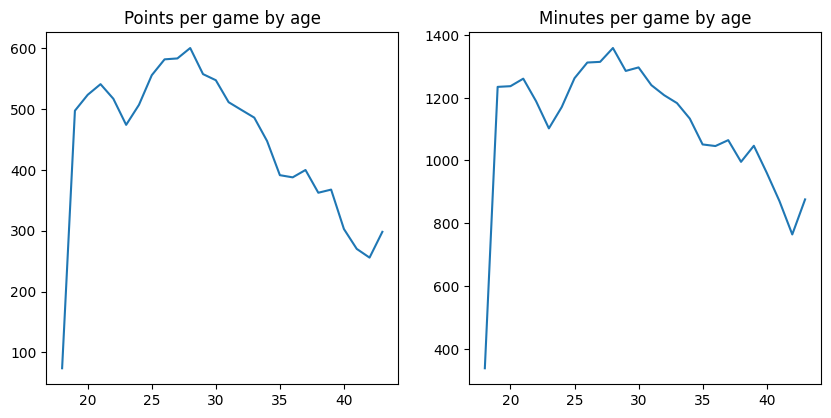

In [12]:
fig, ax = plt.subplots(nrows=1 ,ncols=2, figsize=(10, 6))
sns.lineplot(x=ages, y=point_means, ax=ax[0])
sns.lineplot(x=ages, y=min_means, ax=ax[1])
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
ax[0].set_title('Points per game by age')
ax[1].set_title('Minutes per game by age');

Obviously we have to adjust most measures, normalizing by minutes. <br>

In the meantime we can check 'FG_PCT', 'FG3_PCT', and 'FT_PCT' as they are already normalized:

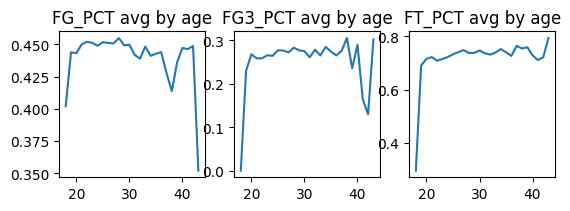

In [13]:
fig, ax = plt.subplots(nrows=1 ,ncols=3, )
sns.lineplot(x=ages, y=fg_pct_means, ax=ax[0])
sns.lineplot(x=ages, y=three_pct_means, ax=ax[1])
sns.lineplot(x=ages, y=ft_pct_means, ax=ax[2])
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
ax[2].set_aspect(1.0/ax[2].get_data_ratio(), adjustable='box')
ax[0].set_title('FG_PCT avg by age')
ax[1].set_title('FG3_PCT avg by age')
ax[2].set_title('FT_PCT avg by age');

Aside from "very young" and "very old" players, the age seems to matter little in scoring. 

In the treatment group and trades, obviously age plays a role:

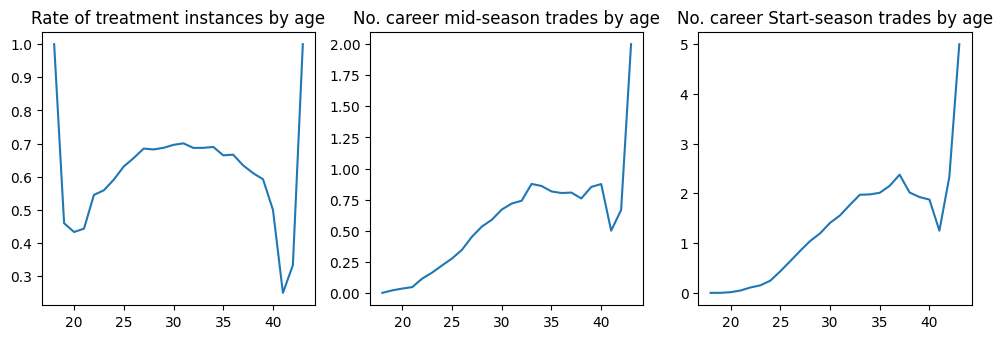

In [14]:
fig, ax = plt.subplots(nrows=1 ,ncols=3, figsize=(12, 4))
sns.lineplot(x=ages, y=treatment_means, ax=ax[0])
sns.lineplot(x=ages, y=mid_season_trades_means, ax=ax[1])
sns.lineplot(x=ages, y=start_of_season_trades_means, ax=ax[2])
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')
ax[1].set_aspect(1.0/ax[1].get_data_ratio(), adjustable='box')
ax[2].set_aspect(1.0/ax[2].get_data_ratio(), adjustable='box')
ax[0].set_title('Rate of treatment instances by age')
ax[1].set_title('No. career mid-season trades by age')
ax[2].set_title('No. career Start-season trades by age');

Let's just normalize by minutes, drop no instances.

In [15]:
def normalize_by_min(df=career_df, cols=career_df.columns, mins=career_df['MIN']):
    for col in cols:
        df[col] = df[col]/mins
        df = df.rename(columns={col: col + '_PM'})
    return df

norm_cols = ['PTS', 'AST', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'STL',
             'BLK', 'TOV', 'PF', ]
career_df["MIN_PG"] =career_df["MIN"] / career_df["GP"]
career_df["PTS_PG"] =career_df["PTS"] / career_df["GP"]
career_df = normalize_by_min(career_df, cols=norm_cols, mins=career_df['MIN'])
#career_df["AST_PG"] =career_df["AST"] / career_df["GP"]
career_df.head()

,PLAYER_ID,SEASON_ID,YEAR,TEAM_ABBREVIATION,TREATMENT,AFTER_N_MIDSEASON_TRADES,AFTER_N_START_OF_SEASON_TRADES,TRADED_THIS_SEASON,PLAYER_AGE,GP,...,REB_PM,AST_PM,STL_PM,BLK_PM,TOV_PM,PF_PM,TEAM_ID,LEAGUE_ID,MIN_PG,PTS_PG
0,949,2003-04,2003,ATL,1,0,0,1,27.0,53,...,0.253197,0.064962,0.022506,0.009719,0.067008,0.075192,1610612737,0,36.886792,20.094340
1,949,2003-04,2003,POR,1,1,0,1,27.0,32,...,0.197531,0.064472,0.032922,0.024691,0.072702,0.102881,1610612757,0,22.781250,9.968750
2,949,2004-05,2004,POR,1,1,0,0,28.0,54,...,0.209850,0.059422,0.026231,0.013919,0.062634,0.080300,1610612757,0,34.592593,16.833333
3,949,2005-06,2005,SAC,1,1,1,0,29.0,72,...,0.182050,0.075982,0.024477,0.021418,0.055074,0.115757,1610612758,0,27.236111,12.319444
4,949,2006-07,2006,SAC,1,1,1,0,30.0,80,...,0.197519,0.054094,0.026303,0.019851,0.057568,0.120596,1610612758,0,25.187500,9.912500


Great. We do not need to change the biography data, let's "perfectly" combine the two datasets:

In [16]:
ids_bio = bios_df['PLAYER_ID'].unique()
ids_career = career_df['PLAYER_ID'].unique()
ids = np.intersect1d(ids_bio, ids_career)

bios_df_ = bios_df[bios_df['PLAYER_ID'].isin(ids) ].reset_index(drop=True)
career_df_ = career_df[career_df['PLAYER_ID'].isin(ids) ].reset_index(drop=True)

#Find all common id-season pairs
id_season_pairs_bio = (bios_df_[['PLAYER_ID', 'SEASON_ID']].to_numpy().tolist())
id_season_pairs_career = career_df_[['PLAYER_ID', 'SEASON_ID']].to_numpy().tolist()
A = set(tuple(x) for x in id_season_pairs_bio); B = set(tuple(x) for x in id_season_pairs_career)
id_season_pairs = ([x for x in A & B])


bios_df_ = bios_df_[bios_df_[['PLAYER_ID', 'SEASON_ID']].apply(tuple, axis=1).isin(id_season_pairs) ].reset_index(drop=True)
bios_df_ = bios_df_.drop(columns=['TEAM_ID', 'TEAM_ABBREVIATION',]).rename(columns={'GP': 'GP_SEASON', 'PTS': 'PTS_SEASON', 'REB': 'REB_SEASON',
                                                                                    'AST': 'AST_SEASON', 'OREB_PCT': 'OREB_PCT_SEASON',
                                                                                    'DREB_PCT': 'DREB_PCT_SEASON', 'USG_PCT': 'USG_PCT_SEASON',
                                                                                    'TS_PCT': 'TS_PCT_SEASON', 'AST_PCT': 'AST_PCT_SEASON',
                                                                                    'NET_RATING': 'NET_RATING_SEASON'})
career_df_ = career_df_[career_df_[['PLAYER_ID', 'SEASON_ID']].apply(tuple, axis=1).isin(id_season_pairs) ].reset_index(drop=True)
data = pd.merge(career_df_, bios_df_, on=['PLAYER_ID', 'SEASON_ID'], how='inner')
data = (data.drop(columns=['PLAYER_AGE'])).dropna().reset_index(drop=True)
data.head()

,PLAYER_ID,SEASON_ID,YEAR,TEAM_ABBREVIATION,TREATMENT,AFTER_N_MIDSEASON_TRADES,AFTER_N_START_OF_SEASON_TRADES,TRADED_THIS_SEASON,GP,GS,...,GP_SEASON,PTS_SEASON,REB_SEASON,AST_SEASON,NET_RATING_SEASON,OREB_PCT_SEASON,DREB_PCT_SEASON,USG_PCT_SEASON,TS_PCT_SEASON,AST_PCT_SEASON
0,949,2003-04,2003,ATL,1,0,0,1,53,53,...,85,1384,639,174,-2.4,0.074,0.163,0.244,0.557,0.126
1,949,2003-04,2003,POR,1,1,0,1,32,3,...,85,1384,639,174,-2.4,0.074,0.163,0.244,0.557,0.126
2,949,2004-05,2004,POR,1,1,0,0,54,49,...,54,909,392,111,-5.7,0.069,0.143,0.216,0.581,0.106
3,949,2005-06,2005,SAC,1,1,1,0,72,30,...,72,887,357,149,4.4,0.057,0.133,0.199,0.588,0.130
4,949,2006-07,2006,SAC,1,1,1,0,80,45,...,80,793,398,109,-4.4,0.062,0.148,0.194,0.524,0.092


### 0-e) What attributes might be relevant? (& feature engineering)

Let's go through all categories, and consider their relationship to `x` (being traded) and `y` (minutes):

Performance statistics in general: these matter, as they are common causes of being traded and minutes played.

- Age: Can possibly matter, we must include it. Younger players for example might be more likely to be traded, moreover age is related to the amount of minutes played on average (common cause).
- FG, FG3, FT: Performance statistics, so we certainly have to keep some of them.<br>For free throws, attempted free throws likely isn't relevant, scored free throws are also likely not important, rather the percentage, which we can include to make sure. Free throws aren't most key for getting playtime.<br>
With similar reasoning, I keep the field goal and 3-pointer percentages.<br>
- PTS: Including the PTS/per game ratio might also be relevant.<br>
- REB: It is worthy to keep both OREB and DREB. Since we don't have a position attribute, these are fairly good indicators instead and may be important to control on. Directly, they are performance statistics, indirectly they might indicate position.<br>
- BLK, TOV, STL, PF: Performance statistics, let's keep them.<br>
- AST: Point guards typically have high number of assists, centers not - keep it for the reasons that it is a performance statistic, and it might indicate position.<br>

- Height, weight, college, country, draft: Hopefully, these are not relevant in any form. Draft number may be relevant for the reason that earlier picks are the higher rated and typically the better players.<br>
- NET_RATING, USG: They can be useful general performance statistics, the only problem is these are not available. Nonetheless, can help capture reverse causality for example.<br>
- Games played/started: These could be useful to control on for reverse causality, but I will instead use leads.<br>


What else?

- Position: Can play a significant role in minutes played, performance statistics, and arguably correlates with being traded (forwards get traded more often), so is endogeneous to `y`. However, there was no data particularly on which position a player is playing preferably, and I use other attributes to try to indicate this information. (Typically, there are 5 positions: Point guard, Shooting guard, Small forward, Power forward, Center, but some roles are interchangable.)<br>
- Injuries: No data. <br>
- Reverse causality: Playing badly and not playing much can lead to being traded - to control for this, we can use leads
- Lags: It may take time to adjust to a new team, so effect might be delayed -> add lags.<br>
- The number of seasons the player has played.


We can see the relationship between trades and other variables:

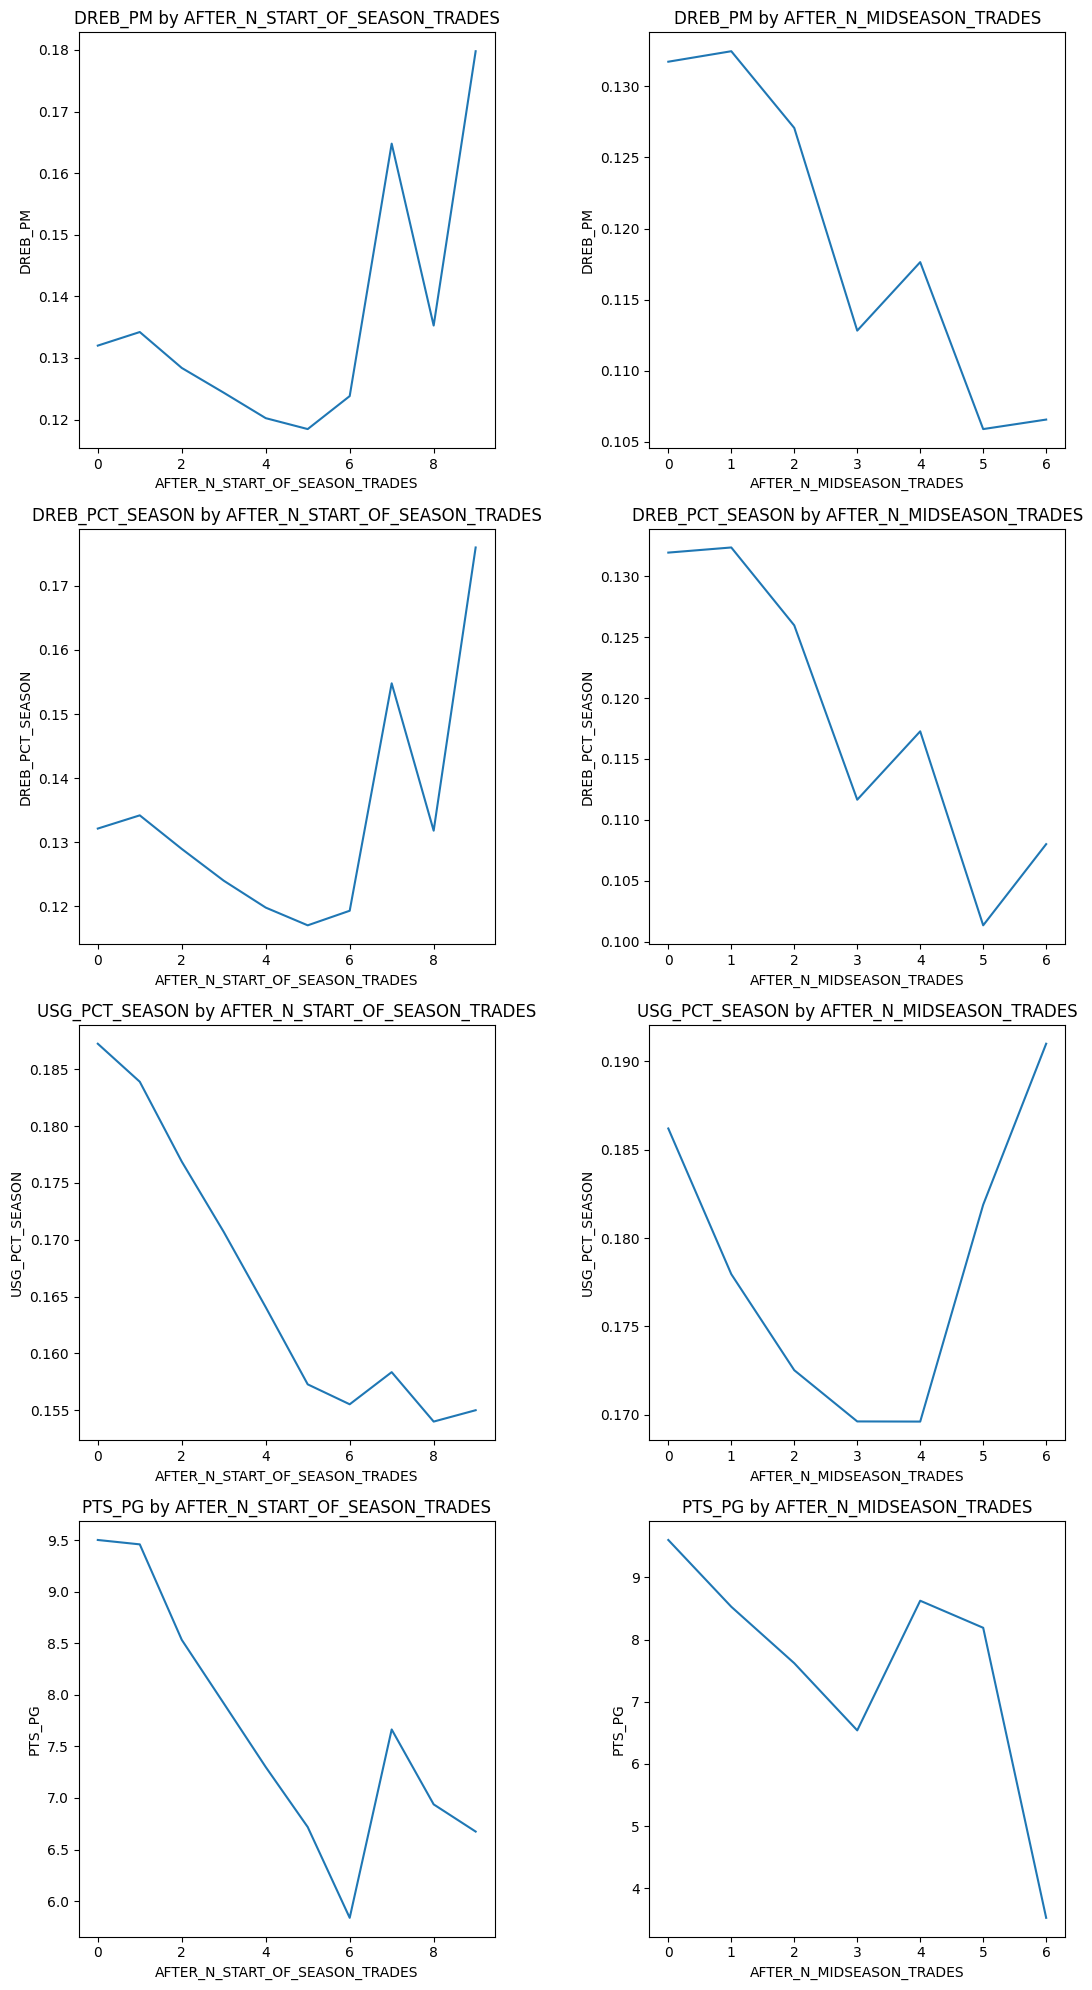

In [17]:
plotting.plot_As_by_Bs_and_Cs(data, As=['DREB_PM', 'DREB_PCT_SEASON', 'USG_PCT_SEASON', 'PTS_PG'], Bs=['AFTER_N_START_OF_SEASON_TRADES']*4, Cs=['AFTER_N_MIDSEASON_TRADES']*4)

Save our data:

In [18]:
data = data.sort_values(['PLAYER_ID', 'SEASON_ID', 'AFTER_N_MIDSEASON_TRADES'], ascending=[True, True, True]).reset_index(drop=True)
data.to_csv('data\data_combined.csv', index=False)

## 2. Models

Let's prepare some new (e.g. lagged) features, and then we can start with the models.

In [19]:
data["AFTER_N_MIDSEASON_TRADES_lag1"] = data.groupby("PLAYER_ID")["AFTER_N_MIDSEASON_TRADES"].shift(1)
data["AFTER_N_START_OF_SEASON_TRADES_lag1"] = data.groupby("PLAYER_ID")["AFTER_N_START_OF_SEASON_TRADES"].shift(1)
data["MINS_lag1"] = data.groupby("PLAYER_ID")["MIN"].shift(1)
data["MIN_PG_lag1"] = data.groupby("PLAYER_ID")["MIN_PG"].shift(1)
data["AFTER_N_MIDSEASON_TRADES_lag2"] = data.groupby("PLAYER_ID")["AFTER_N_MIDSEASON_TRADES"].shift(2)
data["AFTER_N_START_OF_SEASON_TRADES_lag2"] = data.groupby("PLAYER_ID")["AFTER_N_START_OF_SEASON_TRADES"].shift(2)
#data["MINS_lag2"] = data.groupby("PLAYER_ID")["MIN"].shift(2)
data["NET_RATING_SEASON_lag1"] = data.groupby("PLAYER_ID")["NET_RATING_SEASON"].shift(1)

data["MINS_lead1"] = data.groupby("PLAYER_ID")["MIN"].shift(-1)
data["MIN_PG_lead1"] = data.groupby("PLAYER_ID")["MIN_PG"].shift(-1)
data["AFTER_N_MIDSEASON_TRADES_lead1"] = data.groupby("PLAYER_ID")["AFTER_N_MIDSEASON_TRADES"].shift(-1)
data["AFTER_N_START_OF_SEASON_TRADES_lead1"] = data.groupby("PLAYER_ID")["AFTER_N_START_OF_SEASON_TRADES"].shift(-1)

data["d_AFTER_N_MIDSEASON_TRADES"] = data.groupby("PLAYER_ID")["AFTER_N_MIDSEASON_TRADES"].diff()
data["d_AFTER_N_START_OF_SEASON_TRADES"] = data.groupby("PLAYER_ID")["AFTER_N_START_OF_SEASON_TRADES"].diff()
data["d_MINS"] = data.groupby("PLAYER_ID")["MIN"].diff()
data["d_MIN_PG"] = data.groupby("PLAYER_ID")["MIN_PG"].diff()

first_years = data.groupby("PLAYER_ID")["YEAR"].min()
data["time_trend"] = data.apply(lambda x: x["YEAR"] - first_years[x["PLAYER_ID"]], axis=1)
data["d_time_trend"] = data.groupby("PLAYER_ID")["time_trend"].diff()

data["d_AFTER_N_MIDSEASON_TRADES_lag1"] = data.groupby("PLAYER_ID")["d_AFTER_N_MIDSEASON_TRADES"].shift(1)
data["d_AFTER_N_START_OF_SEASON_TRADES_lag1"] = data.groupby("PLAYER_ID")["d_AFTER_N_START_OF_SEASON_TRADES"].shift(1)
data["d_MINS_lag1"] = data.groupby("PLAYER_ID")["d_MINS"].shift(1)
data["d_MIN_PG_lag1"] = data.groupby("PLAYER_ID")["d_MIN_PG"].shift(1)
data["d_AFTER_N_MIDSEASON_TRADES_lag2"] = data.groupby("PLAYER_ID")["d_AFTER_N_MIDSEASON_TRADES"].shift(2)
data["d_AFTER_N_START_OF_SEASON_TRADES_lag2"] = data.groupby("PLAYER_ID")["d_AFTER_N_START_OF_SEASON_TRADES"].shift(2)
#data["d_MINS_lag2"] = data.groupby("PLAYER_ID")["d_MINS"].shift(2)
data["d_NET_RATING_SEASON_lag1"] = data.groupby("PLAYER_ID")["NET_RATING_SEASON"].shift(1)

data["d_MINS_lead1"] = data.groupby("PLAYER_ID")["d_MINS"].shift(-1)
data["d_MIN_PG_lead1"] = data.groupby("PLAYER_ID")["d_MIN_PG"].shift(-1)
data["d_AFTER_N_MIDSEASON_TRADES_lead1"] = data.groupby("PLAYER_ID")["d_AFTER_N_MIDSEASON_TRADES"].shift(-1)
data["d_AFTER_N_START_OF_SEASON_TRADES_lead1"] = data.groupby("PLAYER_ID")["d_AFTER_N_START_OF_SEASON_TRADES"].shift(-1)

data["d_AGE"] = data.groupby("PLAYER_ID")["AGE"].diff()
data["d_FG_PCT"] = data.groupby("PLAYER_ID")["FG_PCT"].diff()
data["d_FG3_PCT"] = data.groupby("PLAYER_ID")["FG3_PCT"].diff()
data["d_FT_PCT"] = data.groupby("PLAYER_ID")["FT_PCT"].diff()
data["d_PTS_PG"] = data.groupby("PLAYER_ID")["PTS_PG"].diff()
data["d_AST_PM"] = data.groupby("PLAYER_ID")["AST_PM"].diff()
data["d_DREB_PM"] = data.groupby("PLAYER_ID")["DREB_PM"].diff()
data["d_OREB_PM"] = data.groupby("PLAYER_ID")["OREB_PM"].diff()
data["d_STL_PM"] = data.groupby("PLAYER_ID")["STL_PM"].diff()
data["d_BLK_PM"] = data.groupby("PLAYER_ID")["BLK_PM"].diff()
data["d_TOV_PM"] = data.groupby("PLAYER_ID")["TOV_PM"].diff()
data["d_PF_PM"] = data.groupby("PLAYER_ID")["PF_PM"].diff()
data["d_USG_PCT_SEASON"] = data.groupby("PLAYER_ID")["USG_PCT_SEASON"].diff()
data["d_NET_RATING_SEASON"] = data.groupby("PLAYER_ID")["NET_RATING_SEASON"].diff()

data["d_GP"] = data.groupby("PLAYER_ID")["GP"].diff()
data["d_GS"] = data.groupby("PLAYER_ID")["GS"].diff()

y = 'MIN_PG'
x = 'AFTER_N_MIDSEASON_TRADES'
t = 'time_trend'
x_l1 = 'AFTER_N_MIDSEASON_TRADES_lag1'
x_l2 = 'AFTER_N_MIDSEASON_TRADES_lag2'
y_le1 = 'MIN_PG_lead1'
x_le1 = 'AFTER_N_MIDSEASON_TRADES_lead1'
z1 = 'AGE'
z2 = 'FG_PCT'
z3 = 'FG3_PCT'
z4 = 'FT_PCT'
z5 = 'PTS_PG'
z6 = 'AST_PM'
z7 = 'DREB_PM'
z8 = 'OREB_PM'
z9 = 'STL_PM'
z10 = 'BLK_PM'
z11 = 'TOV_PM'
z12 = 'PF_PM'
z13 = 'NET_RATING_SEASON'
z14 = 'NET_RATING_SEASON_lag1'

dy = 'd_MIN_PG'
dx = 'd_AFTER_N_MIDSEASON_TRADES'
dt = "d_time_trend"
dx_l1 = 'd_AFTER_N_MIDSEASON_TRADES_lag1'
dx_l2 = 'd_AFTER_N_MIDSEASON_TRADES_lag2'
dy_le1 = 'd_MIN_PG_lead1'
dx_le1 = 'd_AFTER_N_MIDSEASON_TRADES_lead1'
dz1 = 'd_AGE'
dz2 = 'd_FG_PCT'
dz3 = 'd_FG3_PCT'
dz4 = 'd_FT_PCT'
dz5 = 'd_PTS_PG'
dz6 = 'd_AST_PM'
dz7 = 'd_DREB_PM'
dz8 = 'd_OREB_PM'
dz9 = 'd_STL_PM'
dz10 = 'd_BLK_PM'
dz11 = 'd_TOV_PM'
dz12 = 'd_PF_PM'
dz13 = 'd_NET_RATING_SEASON'
dz14 = 'd_NET_RATING_SEASON_lag1'

diff_attr_confounders = [dz1, dz2, dz3, dz4, dz5, dz6, dz7, dz8, dz9, dz10, dz11, dz12, dz13, #dz14
                    ]
confounders = [dt, dx_l1, dx_l2, dy_le1] + diff_attr_confounders

### 2-a) Check outliers

There are some outliers in the data, where before or after the trade, the player played significantly more matches than half a season amount. The amount of matches in a season is 82 + few special matches, on average 41 per half season, the mid-season trade window can change this for a player by about $\pm$ 10-12 matches (if they sign at the very beginning of the window, they most likely did not play more than 41-12=29 matches so far that season).

We can filter out very high difference values from the treatment group.

In [20]:
data_intervention = data[data["TRADED_THIS_SEASON"] == 1]
data_intervention.loc[:,'AFTER']= data_intervention.groupby(["PLAYER_ID","SEASON_ID"])['AFTER_N_MIDSEASON_TRADES'].diff().replace({np.nan: 0})

before_cases = data_intervention[data_intervention["AFTER"] == 0]
after_cases = data_intervention[data_intervention["AFTER"] == 1]
before_mean = before_cases["MIN_PG"].mean()
after_mean = after_cases["MIN_PG"].mean()

c:\Users\hanic\miniforge3\envs\da4_case\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\hanic\miniforge3\envs\da4_case\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Let's check out the distribution of matches played (and minutes per game) for both groups:

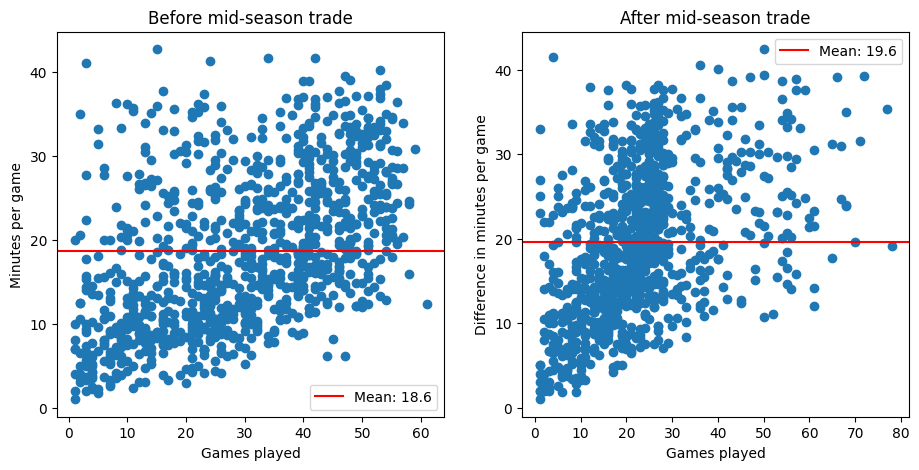

In [21]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.scatter(before_cases["GP"], before_cases["MIN_PG"])
plt.xlabel("Games played")
plt.ylabel("Minutes per game")
plt.title("Before mid-season trade")
plt.axhline(y=before_mean, color='r', linestyle='-', label=f'Mean: {before_mean:.1f}')
plt.legend();

plt.subplot(1, 2, 2)
plt.scatter(after_cases["GP"], after_cases["MIN_PG"])
plt.xlabel("Games played")
plt.ylabel("Difference in minutes per game")
plt.title("After mid-season trade")
plt.axhline(y=after_mean, color='r', linestyle='-', label=f'Mean: {after_mean:.1f}')

plt.legend();

Already we see the average increase by 1 minute. However, we see outliers, mostly in the after trade group, some even played ~80 matches, these must be non-mid-season trades. Let's filter out these:

In [22]:
too_active_players = data_intervention.groupby(['PLAYER_ID', 'SEASON_ID']).filter(lambda x: (x['GP'] > 55).any())['PLAYER_ID'].unique()
data_intervention = data_intervention[~data_intervention['PLAYER_ID'].isin(too_active_players)]

In [23]:
before_cases = data_intervention[data_intervention["AFTER"] == 0]
after_cases = data_intervention[data_intervention["AFTER"] == 1]
before_mins_mean = before_cases["MIN_PG"].mean()
after_mins_mean = after_cases["MIN_PG"].mean()
d_mins_mean = after_mins_mean - before_mins_mean
before_games_mean = before_cases["GP"].mean()
after_games_mean = after_cases["GP"].mean()
d_games_mean = after_games_mean - before_games_mean

Now we can check how the difference in matches played and minutes per game looks like (remember, these are only the treatment groups):

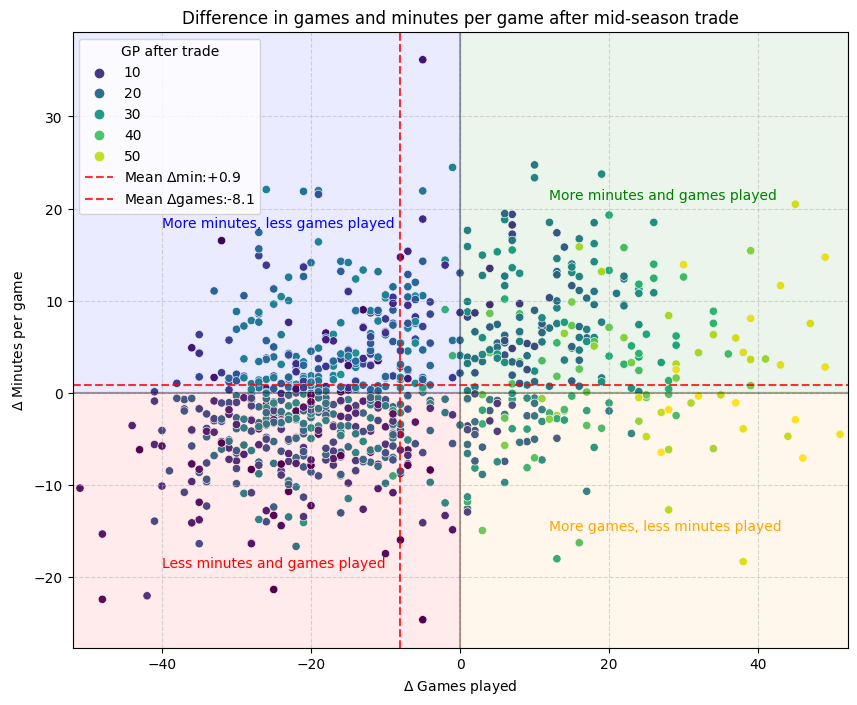

In [24]:
min_min = after_cases["d_MIN_PG"].min()
min_max = after_cases["d_MIN_PG"].max()
games_min = after_cases["d_GP"].min()
games_max = after_cases["d_GP"].max()

plt.figure(figsize=(10, 8))
sns_plot = sns.scatterplot(x="d_GP", y="d_MIN_PG", hue="GP", data=after_cases, palette="viridis");
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(y=d_mins_mean, color='r', linestyle='--', label=r'Mean $\Delta$min:' + f'+{d_mins_mean:.1f}', alpha=0.8)
plt.axvline(x=d_games_mean, color='r', linestyle='--', label=r'Mean $\Delta$games:' + f'{d_games_mean:.1f}', alpha=0.8)

plt.legend();

plt.axvspan(-52, 0, color='red', alpha=0.08, ymax=min_min/(min_min-min_max)+0.01)
plt.axvspan(-52, 0, color='blue', alpha=0.08, ymin=min_min/(min_min-min_max)+0.01)
plt.axvspan(0, 52, color='orange', alpha=0.08, ymax=min_min/(min_min-min_max)+0.01)
plt.axvspan(0, 52, color='green', alpha=0.08, ymin=min_min/(min_min-min_max)+0.01)


plt.title("Difference in games and minutes per game after mid-season trade");
#use delta letter for text on plot
plt.xlabel(r'$\Delta$ Games played')
plt.ylabel(r'$\Delta$ Minutes per game')
plt.text(-40, -19, r'Less minutes and games played', color='red')
plt.text(12, -15, r'More games, less minutes played', color='orange')
plt.text(-40, 18, r'More minutes, less games played', color='blue')
plt.text(12, 21, r'More minutes and games played', color='green');
plt.xlim(-52, 52)

handles, labels = sns_plot.get_legend_handles_labels()

order = [2,3,4,5,6,0,1]
sns_plot.legend(handles=[handles[i] for i in order], labels=[labels[i] for i in order], title="GP after trade");

### 2-a) Diff-in-diff

Here, we want to just check with a simple diff-in-diff model whether the in-season change in minutes played is different for traded players compared to non-traded players.

Because of the way the data is collected (there is no middle-of-the-season data for players that did not change teams), we have to assume a 0 effect in change for the control group. This is not ideal, but it is the best we can do with the data we have. We add every untreated instace as two instances, with one having AFTER = 0, other having AFTER = 1.

In [25]:
data_intervention_added = data_intervention.copy()
data_added = data[data["TRADED_THIS_SEASON"] == 0].copy()
data_added["AFTER"] = 0
data_added_2 = data_added.copy()
data_added_2["AFTER"] = 1
data_added = data_added.append(data_added_2, ignore_index=True)
data_intervention_added = data_intervention_added.append(data_added, ignore_index=True)

In [26]:
fit = smf.ols(f'{y} ~ TREATMENT + AFTER + TREATMENT*AFTER', data=data_intervention_added.dropna(subset=[y])).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MIN_PG   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.58
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           6.05e-07
Time:                        23:53:42   Log-Likelihood:                -56264.
No. Observations:               15597   AIC:                         1.125e+05
Df Residuals:                   15593   BIC:                         1.126e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          21.7723      0.156    139.862      0.000      21.467      22.077
TREATMENT           0.7159      0.205      3.499      0.000       0.315       1.117
AFTER            4.909e-13      0.220   2.23e-12      1.000      -0.432       0.432
TREATMENT:AFTER     0.1756      0.289      0.607      0.544      -0.392       0.743
==============================================================================
Omnibus:                     4127.574   Durbin-Watson:                   0.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              686.893
Skew:                           0.030   Prob(JB):                    6.97e-150
Kurtosis:                       1.974   Cond. No.                         7.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see that the treated players on average play 2 minutes more than nontreated players - this is surprising, as they are expected to play less due to them being treated. The average amount of minutes played is 19 minutes per game for the untreated group, which is quite low (one match is 48 minutes), which might suggest that non-starters bring down the average. The diff-in-diff estimate only adds 0.2 minutes per game, which is not significant.

In [27]:
smf_model = f"{y} ~ TREATMENT + AFTER + TREATMENT*AFTER + {t} + {x_l1} + {x_l2} + {x_le1} + \
            {z1} + {z2} + {z3} + {z4} + {z5} + {z6} + {z7} + \
            {z8} + {z9} + {z10} + {z11} + {z12} + {z13} + {z14} + \
            {t}*AFTER + {x_l1}*AFTER + {x_l2}*AFTER + {x_le1}*AFTER + \
            {z1}*AFTER + {z2}*AFTER + {z3}*AFTER + {z4}*AFTER + {z5}*AFTER + {z6}*AFTER + {z7}*AFTER + \
            {z8}*AFTER + {z9}*AFTER + {z10}*AFTER + {z11}*AFTER + {z12}*AFTER + {z13}*AFTER + {z14}*AFTER"
fit = smf.ols(smf_model, data=data_intervention_added.dropna(subset=[y])).fit()

print("Beta1:", fit.params["TREATMENT:AFTER"],)
fit.summary()

Beta1: 0.01043385706910743


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MIN_PG   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     737.5
Date:                Mon, 10 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:53:42   Log-Likelihood:                -23467.
No. Observations:                8467   AIC:                         4.701e+04
Df Residuals:                    8427   BIC:                         4.730e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               15.6789      1.005     15.597      0.000      13.708      17.649
TREATMENT                                1.0277      0.147      6.973      0.000       0.739       1.317
AFTER                                    2.0214      1.451      1.393      0.164      -0.824       4.866
TREATMENT:AFTER                          0.0104      0.210      0.050      0.960      -0.400       0.421
time_trend                              -0.2159      0.029     -7.535      0.000      -0.272      -0.160
AFTER_N_MIDSEASON_TRADES_lag1            1.2364      0.258      4.801      0.000       0.732       1.741
AFTER_N_MIDSEASON_TRADES_lag2            0.4577      0.217      2.106      0.035       0.032       0.884
AFTER_N_MIDSEASON_TRADES_lead1          -2.0392      0.182    -11.205      0.000      -2.396      -1.682
AGE                                      0.1756      0.023      7.638      0.000       0.131       0.221
FG_PCT                                   1.8151      1.186      1.531      0.126      -0.509       4.139
FG3_PCT                                 -2.7329      0.501     -5.451      0.000      -3.716      -1.750
FT_PCT                                  -2.4815      0.560     -4.429      0.000      -3.580      -1.383
PTS_PG                                   1.0765      0.015     72.240      0.000       1.047       1.106
AST_PM                                  12.4917      1.612      7.748      0.000       9.331      15.652
DREB_PM                                 -1.6572      1.611     -1.029      0.304      -4.814       1.500
OREB_PM                                  9.7713      3.356      2.912      0.004       3.194      16.349
STL_PM                                  21.4630      5.182      4.142      0.000      11.306      31.620
BLK_PM                                  12.3611      4.251      2.908      0.004       4.027      20.695
TOV_PM                                 -52.4235      4.297    -12.200      0.000     -60.847     -44.000
PF_PM                                  -46.7624      2.695    -17.352      0.000     -52.045     -41.480
NET_RATING_SEASON                        0.0092      0.012      0.761      0.447      -0.014       0.033
NET_RATING_SEASON_lag1                   0.0354      0.012      3.019      0.003       0.012       0.058
time_trend:AFTER                         0.0120      0.041      0.295      0.768      -0.068       0.092
AFTER_N_MIDSEASON_TRADES_lag1:AFTER     -0.7055      0.363     -1.943      0.052      -1.417       0.006
AFTER_N_MIDSEASON_TRADES_lag2:AFTER      0.0276      0.322      0.086      0.932      -0.603       0.659
AFTER_N_MIDSEASON_TRADES_lead1:AFTER     0.6085      0.269      2.265      0.024       0.082       1.135
AGE:AFTER                             

Findings:

- Intercept decreased to just 10 minutes - the average that a no score, no foul etc. player would play per match
- Players that were traded played on average +1.29mins / match than those who were not traded - smaller effect than before, still significant
- Diff-in-diff: The coefficient grew to 0.194 minutes increase per match, similar to before. Nonsignificant, but an increase overall in time for being traded in the middle of the season. Lagged 1x -> increase in 0.97 minutes per match for each mid season trade in their career, and 2-times lagged values also add a 0.45 increase in minutes per match.
- Age: +0.2 for 1 year diff (significant), however, the number of seasons of a player counters with a decrease of -0.13.
- Field goal percentage: +4.5mins for each 1% increase in field goal percentage (significant)
- 3pointers%: Interestingly, the higher the %, the lower the minutes played, by -1.85 for each percentage (note that these percentages are in any case low). It might be because guards get traded more often, and guards score more 3-pointers, an indicator of position.

- Assist per min: Increase, for every 1 more assist per 10 minutes, an increase of playtime by 0.48 minutes (significant)
- Defensive rebounds per min: This confounder is on the border of being significant. Overall would be a positive statistic, but as a position indicator (guards, centers have high defensive rebounds), it also carries negative effects (forwards are usually the key players, who play the most), so overall a small, almost significant but negative impact. On the contrary, general (less related to position) defensive stats e.g. steals and blocks are significant and positive.
- Two very significant statistics, turnovers and personal fouls, and even the first difference in personal fouls, show how there is a bias against those who make mistakes, they are more likely to be not played.
- Net rating: significant, surprisingly decreases the played minutes per match, but the lagged version increases it: higher net rating before results in more minutes now.

Overall, the effect is nonsignificant, not even just in measuring the impact in one season.

### 2-b) Panel first differences

Here, we use a panel first differences model with time and entity fixed effects (which probably are not necessary, but can't hurt). In this case, we are interested in the long-term effect of being traded in the middle of the season on minutes played. The causal variable in this case is the number of mid-season trades a player has experienced.

In [28]:
model = f"{dy} ~ {dx} + {dt} + {dx_l1} + {dx_l2} + {dx_le1} + \
          {dz1} + {dz2} + {dz3} + {dz4} + {dz5} + {dz6} + {dz7} + \
          {dz8} + {dz9} + {dz10} + {dz11} + {dz12} + {dz13} + {dz14} \
          + TimeEffects + EntityEffects"
fit = PanelOLS.from_formula(model, 
    data=data.set_index(["PLAYER_ID", "YEAR"],).dropna(subset=[dy]+confounders),
    ).fit()
print("Beta1:", fit.params[dx], " with p-value:", fit.pvalues[dx])
fit.summary

Beta1: 0.14758121307536531  with p-value: 0.7232532384900217


Dep. Variable:,d_MIN_PG,R-squared:,0.6605
Estimator:,PanelOLS,R-squared (Between):,0.7358
No. Observations:,4082,R-squared (Within):,0.6680
Date:,"Mon, Mar 10 2025",R-squared (Overall):,0.6831
Time:,23:53:42,Log-likelihood,-1.026e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,335.75
Entities:,1397,P-value,0.0000
Avg Obs:,2.9220,Distribution:,"F(19,3279)"
Min Obs:,0.0000,,
Max Obs:,18.000,F-statistic (robust):,335.75


We see that the effect is not significant - a coefficient of -0.07 with confidence interval going from -0.9 to 0.7 means that likely the effect is miniscule.

- The reverse-causality capturing lead tearm's coefficient is very significant - this makes sense, as the minutes played have an impact on being traded. The fact, that the other way around is not significant, means that there is no long-term impact of being traded on minutes played.
- The difference in field goal percentage, goals per game, assists per minute, are all significant. The free throw percentage change surprisingly also has a significant, but positive impact on difference in minutes played, which is hard to interpret. Possibly the good free throw shooters are the ones that are also good 3-point shooters, which are typically guards that are playing less minutes per match (due to their position).
- Change in age and experience are not significant confounders. Changes in 3-point percentages still have a negative coefficient, but are not statistically significant anymore.
- All changes in defensive statistics, except changes in defensive rebounds, are statistically significant.
- Changes in turnovers and personal fouls are still very significant with a negative impact on minutes played.
- Changes in net rating are not significant, but its lagged version is significant, with a positive impact on minutes played. This seems right, if the net rating increases then the player is more likely to play more minutes, appearantly this effect has a delay.

With R-squared of 68-69% for both the within and general R-squared, the model explains a lot of the variance in the data.

## 3 Robustness checks - starters vs. non-starters

There is a lot of difference if somebody gets traded to get more playtime, or someone who is already a starter gets traded. Let's analyze the two groups separately: anybody who started at least 50% of the matches in the season is considered a starter.

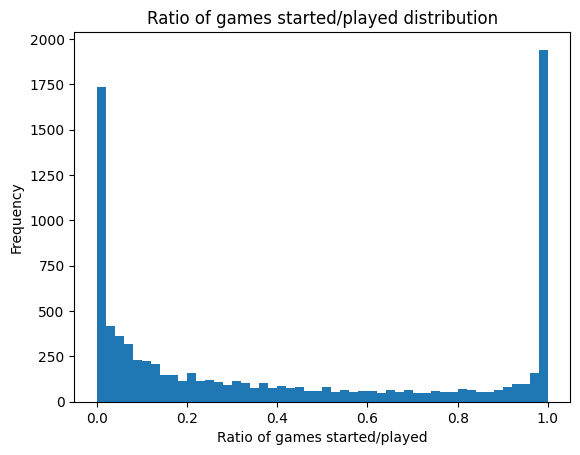

In [29]:
plt.hist(data['GS']/data['GP'], bins=50)
plt.title('Ratio of games started/played distribution')
plt.xlabel('Ratio of games started/played')
plt.ylabel('Frequency');

In [30]:
data['STARTER'] = data['GS']/data['GP'] > 0.5
data_intervention_added['STARTER'] = data_intervention_added['GS']/data_intervention_added['GP'] > 0.5

In [31]:
model = f"{dy} ~ {dx} + {dt} + {dx_l1} + {dx_l2} + {dx_le1} + \
          {dz1} + {dz2} + {dz3} + {dz4} + {dz5} + {dz6} + {dz7} + \
          {dz8} + {dz9} + {dz10} + {dz11} + {dz12} + {dz13} + {dz14} \
          + TimeEffects + EntityEffects"
fit = PanelOLS.from_formula(model, 
    data=data[data['STARTER']==0].set_index(["PLAYER_ID", "YEAR"],).dropna(subset=[dy]+confounders),
    ).fit()
print("Beta1:", fit.params[dx], " with p-value:", fit.pvalues[dx])
fit.summary

Beta1: 0.6779028139432153  with p-value: 0.17035123516699802


Dep. Variable:,d_MIN_PG,R-squared:,0.7759
Estimator:,PanelOLS,R-squared (Between):,0.8000
No. Observations:,1987,R-squared (Within):,0.7757
Date:,"Mon, Mar 10 2025",R-squared (Overall):,0.7863
Time:,23:53:42,Log-likelihood,-4616.0
Cov. Estimator:,Unadjusted,,
,,F-statistic:,242.53
Entities:,1316,P-value,0.0000
Avg Obs:,1.5099,Distribution:,"F(19,1331)"
Min Obs:,0.0000,,
Max Obs:,13.000,F-statistic (robust):,242.53


In [32]:
model = f"{dy} ~ {dx} + {dt} + {dx_l1} + {dx_l2} + {dx_le1} + \
          {dz1} + {dz2} + {dz3} + {dz4} + {dz5} + {dz6} + {dz7} + \
          {dz8} + {dz9} + {dz10} + {dz11} + {dz12} + {dz13} + {dz14} \
          + TimeEffects + EntityEffects"
fit = PanelOLS.from_formula(model, 
    data=data[data['STARTER']==1].set_index(["PLAYER_ID", "YEAR"],).dropna(subset=[dy]+confounders),
    ).fit()
print("Beta1:", fit.params[dx], " with p-value:", fit.pvalues[dx])
fit.summary

Beta1: 0.16994184080033642  with p-value: 0.8253518885315974


Dep. Variable:,d_MIN_PG,R-squared:,0.5584
Estimator:,PanelOLS,R-squared (Between):,0.5761
No. Observations:,2095,R-squared (Within):,0.5650
Date:,"Mon, Mar 10 2025",R-squared (Overall):,0.5602
Time:,23:53:42,Log-likelihood,-4819.9
Cov. Estimator:,Unadjusted,,
,,F-statistic:,102.62
Entities:,748,P-value,0.0000
Avg Obs:,2.8008,Distribution:,"F(19,1542)"
Min Obs:,0.0000,,
Max Obs:,16.000,F-statistic (robust):,102.62


Very interestingly, the results differ significantly from previous results!

- The lead term is no longer significant in either model, which is surprising as we would expect it to capture the reverse causality. It is still more significant for starters however.
- For non-starters (typically amateurs), difference in field goal percentages are significant, but for starters, the opposite are significant: three-point percentages, and free throws.
- Difference in age completely doesn't matter for non-starters, but for starters, it has a significant negative impact on minutes played, likely due to older players are utilized less and less over time.
- Points per game is very significant for both.
- Only certain defensive statistics are significant for non-starters, and for starters none are significant.
- Assists are only significant for starters.
- Turnovers and personal fouls are still significant for both groups.

#### Diff-in-diff for starters and non-starters

In [33]:
smf_model = f"{y} ~ TREATMENT + AFTER + TREATMENT*AFTER + {t} + {x_l1} + {x_l2} + {x_le1} + \
            {z1} + {z2} + {z3} + {z4} + {z5} + {z6} + {z7} + \
            {z8} + {z9} + {z10} + {z11} + {z12} + {z13} + {z14} + \
            {t}*AFTER + {x_l1}*AFTER + {x_l2}*AFTER + {x_le1}*AFTER + \
            {z1}*AFTER + {z2}*AFTER + {z3}*AFTER + {z4}*AFTER + {z5}*AFTER + {z6}*AFTER + {z7}*AFTER + \
            {z8}*AFTER + {z9}*AFTER + {z10}*AFTER + {z11}*AFTER + {z12}*AFTER + {z13}*AFTER + {z14}*AFTER"
fit = smf.ols(smf_model, data=data_intervention_added[data_intervention_added['STARTER']==0].dropna(subset=[y])).fit()

print("Beta1:", fit.params["TREATMENT:AFTER"],)
fit.summary()

Beta1: 0.057976966601502644


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MIN_PG   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     324.0
Date:                Mon, 10 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:53:43   Log-Likelihood:                -9912.6
No. Observations:                3981   AIC:                         1.991e+04
Df Residuals:                    3941   BIC:                         2.016e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               11.5885      1.009     11.480      0.000       9.609      13.568
TREATMENT                               -0.0933      0.177     -0.528      0.598      -0.440       0.253
AFTER                                    1.2996      1.465      0.887      0.375      -1.574       4.173
TREATMENT:AFTER                          0.0580      0.252      0.230      0.818      -0.437       0.553
time_trend                              -0.0872      0.032     -2.745      0.006      -0.149      -0.025
AFTER_N_MIDSEASON_TRADES_lag1            1.1299      0.247      4.578      0.000       0.646       1.614
AFTER_N_MIDSEASON_TRADES_lag2            0.0632      0.212      0.298      0.766      -0.353       0.479
AFTER_N_MIDSEASON_TRADES_lead1          -1.2565      0.179     -7.014      0.000      -1.608      -0.905
AGE                                      0.1159      0.025      4.576      0.000       0.066       0.166
FG_PCT                                  -3.0123      1.142     -2.638      0.008      -5.251      -0.774
FG3_PCT                                 -3.0978      0.527     -5.877      0.000      -4.131      -2.064
FT_PCT                                  -1.2994      0.509     -2.552      0.011      -2.298      -0.301
PTS_PG                                   1.3924      0.024     58.952      0.000       1.346       1.439
AST_PM                                   9.4806      1.879      5.045      0.000       5.796      13.165
DREB_PM                                 -0.7226      1.810     -0.399      0.690      -4.271       2.826
OREB_PM                                 -0.5180      3.400     -0.152      0.879      -7.184       6.148
STL_PM                                  13.5181      5.267      2.566      0.010       3.191      23.845
BLK_PM                                   3.6102      4.602      0.784      0.433      -5.413      12.634
TOV_PM                                 -36.1577      4.218     -8.572      0.000     -44.427     -27.888
PF_PM                                  -14.6174      2.578     -5.671      0.000     -19.671      -9.564
NET_RATING_SEASON                        0.0172      0.012      1.377      0.169      -0.007       0.042
NET_RATING_SEASON_lag1                   0.0308      0.012      2.551      0.011       0.007       0.054
time_trend:AFTER                        -0.0133      0.045     -0.295      0.768      -0.102       0.075
AFTER_N_MIDSEASON_TRADES_lag1:AFTER     -0.5108      0.349     -1.465      0.143      -1.195       0.173
AFTER_N_MIDSEASON_TRADES_lag2:AFTER     -0.0707      0.319     -0.222      0.825      -0.696       0.555
AFTER_N_MIDSEASON_TRADES_lead1:AFTER     0.5355      0.266      2.014      0.044       0.014       1.057
AGE:AFTER                             

In [34]:
data_intervention_added['STARTER'] = data_intervention_added['GS']/data_intervention_added['GP'] > 0.5
smf_model = f"{y} ~ TREATMENT + AFTER + TREATMENT*AFTER + {t} + {x_l1} + {x_l2} + {x_le1} + \
            {z1} + {z2} + {z3} + {z4} + {z5} + {z6} + {z7} + \
            {z8} + {z9} + {z10} + {z11} + {z12} + {z13} + {z14} + \
            {t}*AFTER + {x_l1}*AFTER + {x_l2}*AFTER + {x_le1}*AFTER + \
            {z1}*AFTER + {z2}*AFTER + {z3}*AFTER + {z4}*AFTER + {z5}*AFTER + {z6}*AFTER + {z7}*AFTER + \
            {z8}*AFTER + {z9}*AFTER + {z10}*AFTER + {z11}*AFTER + {z12}*AFTER + {z13}*AFTER + {z14}*AFTER"
fit = smf.ols(smf_model, data=data_intervention_added[data_intervention_added['STARTER']==1].dropna(subset=[y])).fit()

print("Beta1:", fit.params["TREATMENT:AFTER"],)
fit.summary()

Beta1: -0.012249163461880208


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 MIN_PG   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     253.3
Date:                Mon, 10 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:53:43   Log-Likelihood:                -11002.
No. Observations:                4486   AIC:                         2.208e+04
Df Residuals:                    4446   BIC:                         2.234e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               28.3627      1.222     23.209      0.000      25.967      30.759
TREATMENT                                0.7467      0.141      5.285      0.000       0.470       1.024
AFTER                                    0.2235      1.733      0.129      0.897      -3.173       3.620
TREATMENT:AFTER                         -0.0122      0.200     -0.061      0.951      -0.405       0.380
time_trend                              -0.3489      0.029    -12.131      0.000      -0.405      -0.292
AFTER_N_MIDSEASON_TRADES_lag1            0.1994      0.311      0.642      0.521      -0.410       0.809
AFTER_N_MIDSEASON_TRADES_lag2            0.2100      0.255      0.825      0.409      -0.289       0.709
AFTER_N_MIDSEASON_TRADES_lead1          -0.6699      0.220     -3.038      0.002      -1.102      -0.238
AGE                                      0.1423      0.023      6.073      0.000       0.096       0.188
FG_PCT                                  -3.0394      1.480     -2.053      0.040      -5.941      -0.137
FG3_PCT                                 -1.5045      0.536     -2.808      0.005      -2.555      -0.454
FT_PCT                                  -3.3923      0.783     -4.333      0.000      -4.927      -1.857
PTS_PG                                   0.6311      0.017     37.739      0.000       0.598       0.664
AST_PM                                   8.0512      1.662      4.844      0.000       4.793      11.310
DREB_PM                                  0.7388      1.655      0.446      0.655      -2.507       3.984
OREB_PM                                  1.5336      3.804      0.403      0.687      -5.923       8.991
STL_PM                                  27.9314      5.790      4.824      0.000      16.581      39.282
BLK_PM                                  12.9377      4.408      2.935      0.003       4.296      21.579
TOV_PM                                 -30.1118      5.135     -5.864      0.000     -40.179     -20.045
PF_PM                                  -64.8138      3.590    -18.055      0.000     -71.852     -57.776
NET_RATING_SEASON                        0.0062      0.013      0.475      0.635      -0.019       0.032
NET_RATING_SEASON_lag1                   0.0012      0.013      0.090      0.929      -0.024       0.026
time_trend:AFTER                        -0.0013      0.041     -0.033      0.974      -0.081       0.078
AFTER_N_MIDSEASON_TRADES_lag1:AFTER     -0.4293      0.435     -0.986      0.324      -1.282       0.424
AFTER_N_MIDSEASON_TRADES_lag2:AFTER      0.2837      0.369      0.768      0.442      -0.440       1.008
AFTER_N_MIDSEASON_TRADES_lead1:AFTER     0.2144      0.320      0.671      0.502      -0.412       0.841
AGE:AFTER                             

## 4. Conclusion

Likely there are omitted variable biases that we didn't capture, as there is mixed results for different attributes and settings (e.g. the starter vs. nonstarter example). Overall, the effect is not significant neither in the season when it happens, although might have a slight increase, nor in the long term.


It is worthy to think about whether results would differ for other groups of players, and likely there could be notable deviations for various groups, just as there are for starters and non-starter players. It’s worth to consider whether in other countries, would the same findings hold -the answer is likely not as the NBA trade rules are specific and different than in other countries, which may have more fair trades, better impact on playtime. External validity is likely low of these results. 

5.  DISCUSSION

We found no significant causal effect on minutes played per game by changing teams mid-season. This however does not disprove the need for new policies for mid-season trades to protect players. In this work, whilst the used biography and performance data is robust, there is a need different variable to measure to better analyze player satisfaction changes. Unfortunately, there seems to be no data that directly measures this.
The work also needs to be continued to capture heterogeneity better: the results may be on average not significant, but there are “good trades” and “bad trades”, it needs to be further investigated for which groups trades are positive, and for which groups this is negative.

In a way, this work could still suggest a need for a policy, if the results are more positive for other countries. There should be comparisons to other countries with different trade rules, which protect player rights more - if there is a more positive impact of trades in those countries, whilst our work shows no significant change, that could be proof for benefits in switching to other systems.


6. CONCLUSION

	While the results of this analysis do not provide evidence that mid-season trades have a significant impact on playtime of players, it does not disprove that current trade rules are not having a negative impact on players. This is due to the work using an indirect measure of player satisfaction, which is not directly measured in the data. In other settings such as in other countries, the impact of player trade may also show to be positive, suggesting a change in trade rules could be beneficial. 
	The policy suggestion is to analyze more thoroughly the impact of trades on player satisfaction, and to compare the results to other countries with different trade rules. This could provide proper evidence for a change in trade rules, which could benefit the players.
